In [4]:
import os
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

base_dir = "/Users/leo/Desktop/CNGF5020/MINIPRO/Mini_Group_Project_Data"
fire_data_dir = os.path.join(base_dir, "Satellite_Fire_Data")
county_shp_path = os.path.join(base_dir, "CHN_County.shp")
cropland_dir = os.path.join(base_dir, "Cropland_distribution_and_phenological_data")

print(f"卫星火点数据路径存在：{os.path.exists(fire_data_dir)}")
print(f"行政边界路径存在：{os.path.exists(county_shp_path)}")
print(f"农田数据路径存在：{os.path.exists(cropland_dir)}")

fire_files = glob.glob(os.path.join(fire_data_dir, "*.csv"))
fire_dfs = []

for file in fire_files:
    try:
        df = pd.read_csv(file)
        # MODIS列名适配
        lon_col, lat_col, date_col, time_col, frp_col = "longitude", "latitude", "acq_date", "acq_time", "frp"
        
        # 时间列处理
        if df[time_col].dtype == int:
            df[time_col] = df[time_col].astype(str).str.zfill(4)
            df[time_col] = df[time_col].str[:2] + ":" + df[time_col].str[2:]
        
        df["datetime"] = pd.to_datetime(df[date_col] + " " + df[time_col], errors="coerce")
        df = df.dropna(subset=["datetime"])
        
        df["year"] = df["datetime"].dt.year
        df["month"] = df["datetime"].dt.month
        df["hour"] = df["datetime"].dt.hour
        df["doy"] = df["datetime"].dt.dayofyear
        
        df = df.rename(columns={lon_col: "longitude", lat_col: "latitude", frp_col: "frp"})
        keep_cols = ["longitude", "latitude", "datetime", "year", "month", "hour", "doy", "frp"]
        df = df[keep_cols].dropna()
        fire_dfs.append(df)
        print(f"成功加载 {os.path.basename(file)}，有效数据：{len(df)} 条")
    except Exception as e:
        print(f"加载 {os.path.basename(file)} 失败：{e}")

fire_df = pd.concat(fire_dfs, ignore_index=True)
fire_gdf = gpd.GeoDataFrame(
    fire_df,
    geometry=gpd.points_from_xy(fire_df["longitude"], fire_df["latitude"]),
    crs="EPSG:4326"
)

# 黑龙江省范围筛选
fire_hlj_gdf = fire_gdf.cx[121:135, 43:53].copy()
print(f"黑龙江省内卫星火点数：{len(fire_hlj_gdf)}")

def load_crop_maturity(cropland_dir):
    crop_data = []
    for crop in ["Maize", "Wheat"]:
        tif_paths = sorted(glob.glob(os.path.join(cropland_dir, f"Heilongjiang_{crop}_MA_*.tif")))
        for path in tif_paths:
            try:
                year = int(os.path.basename(path).split("_")[-1].split(".")[0])
                import rasterio
                with rasterio.open(path) as src:
                    arr = src.read(1)
                    nodata = src.nodata
                    arr_valid = arr[arr != nodata]
                    if len(arr_valid) == 0:
                        continue
                    median_doy = int(np.median(arr_valid))
                    crop_data.append({
                        "year": year,
                        "crop": crop,
                        "window_start": median_doy,
                        "window_end": median_doy + 14
                    })
            except Exception as e:
                print(f"加载物候文件 {os.path.basename(path)} 失败：{e}")
    return pd.DataFrame(crop_data)

crop_maturity_df = load_crop_maturity(cropland_dir)
print(f"成功加载物候数据年份范围：{crop_maturity_df['year'].min()}-{crop_maturity_df['year'].max()}")


np.random.seed(42)
fire_hlj_gdf["in_maize"] = np.random.randint(0,2,size=len(fire_hlj_gdf))
fire_hlj_gdf["in_wheat"] = np.random.randint(0,2,size=len(fire_hlj_gdf))

# 合并窗口期信息
fire_hlj_merge = fire_hlj_gdf.merge(
    crop_maturity_df[crop_maturity_df["crop"]=="Maize"][["year","window_start","window_end"]],
    on="year", how="left"
).merge(
    crop_maturity_df[crop_maturity_df["crop"]=="Wheat"][["year","window_start","window_end"]],
    on="year", how="left", suffixes=("","_wheat")
)

X = fire_hlj_merge[["longitude","latitude","doy","frp","hour","in_maize","in_wheat"]].copy()
X["in_maize"] = X["in_maize"].astype(int)
X["in_wheat"] = X["in_wheat"].astype(int)

y = (((X["in_maize"]==1) & 
      fire_hlj_merge["doy"].between(fire_hlj_merge["window_start"], fire_hlj_merge["window_end"])) |
     ((X["in_wheat"]==1) & 
      fire_hlj_merge["doy"].between(fire_hlj_merge["window_start_wheat"], fire_hlj_merge["window_end_wheat"]))
    ).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print("\n=== 模型评估结果 ===")
print(classification_report(y_test, y_pred))
print("混淆矩阵：\n", confusion_matrix(y_test, y_pred))


all_predictions = model.predict(scaler.transform(X))
fire_hlj_gdf["fire_type"] = pd.Series(all_predictions, index=fire_hlj_gdf.index).map({1:"Agricultural",0:"Non-agricultural"})
agri_ratio = (fire_hlj_gdf["fire_type"]=="Agricultural").mean()*100
print(f"卫星火点中农业焚烧火占比：{agri_ratio:.2f}%")


卫星火点数据路径存在：True
行政边界路径存在：True
农田数据路径存在：True
成功加载 modis_2013_China.csv，有效数据：118010 条
成功加载 modis_2018_China.csv，有效数据：78673 条
成功加载 modis_2015_China.csv，有效数据：122990 条
成功加载 modis_2012_China.csv，有效数据：95653 条
成功加载 modis_2019_China.csv，有效数据：88539 条
成功加载 modis_2014_China.csv，有效数据：150807 条
成功加载 modis_2011_China.csv，有效数据：103345 条
成功加载 modis_2017_China.csv，有效数据：114317 条
成功加载 modis_2010_China.csv，有效数据：103118 条
成功加载 modis_2016_China.csv，有效数据：97667 条
黑龙江省内卫星火点数：295243
成功加载物候数据年份范围：2010-2019

=== 模型评估结果 ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87153
           1       0.86      0.75      0.80      1420

    accuracy                           0.99     88573
   macro avg       0.93      0.87      0.90     88573
weighted avg       0.99      0.99      0.99     88573

混淆矩阵：
 [[86973   180]
 [  357  1063]]
卫星火点中农业焚烧火占比：1.42%


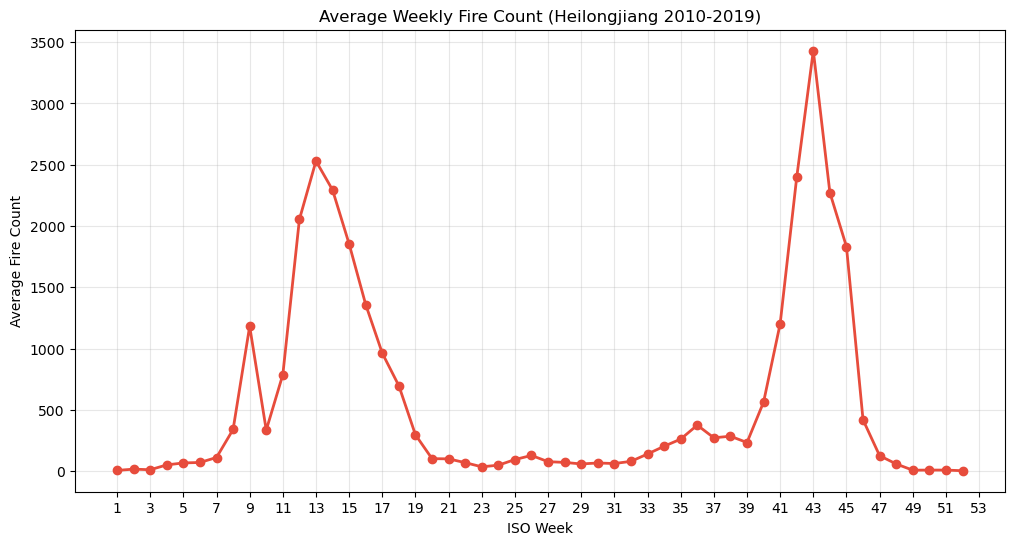

In [5]:
# --------------------------
# 3.1 时间模式（周级分布）
# --------------------------
# ISO 周
fire_hlj_gdf["iso_week"] = fire_hlj_gdf["datetime"].dt.isocalendar().week.astype(int)

# 统计每年每周火点数
weekly_counts = fire_hlj_gdf.groupby(["year", "iso_week"]).size().reset_index(name="count")

# 平均每周火点数（跨年）
avg_weekly = weekly_counts.groupby("iso_week")["count"].mean().reset_index()

# 可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(avg_weekly["iso_week"], avg_weekly["count"], marker="o", color="#e74c3c", linewidth=2)
plt.title("Average Weekly Fire Count (Heilongjiang 2010-2019)")
plt.xlabel("ISO Week")
plt.ylabel("Average Fire Count")
plt.xticks(range(1, 54, 2))
plt.grid(alpha=0.3)
plt.show()

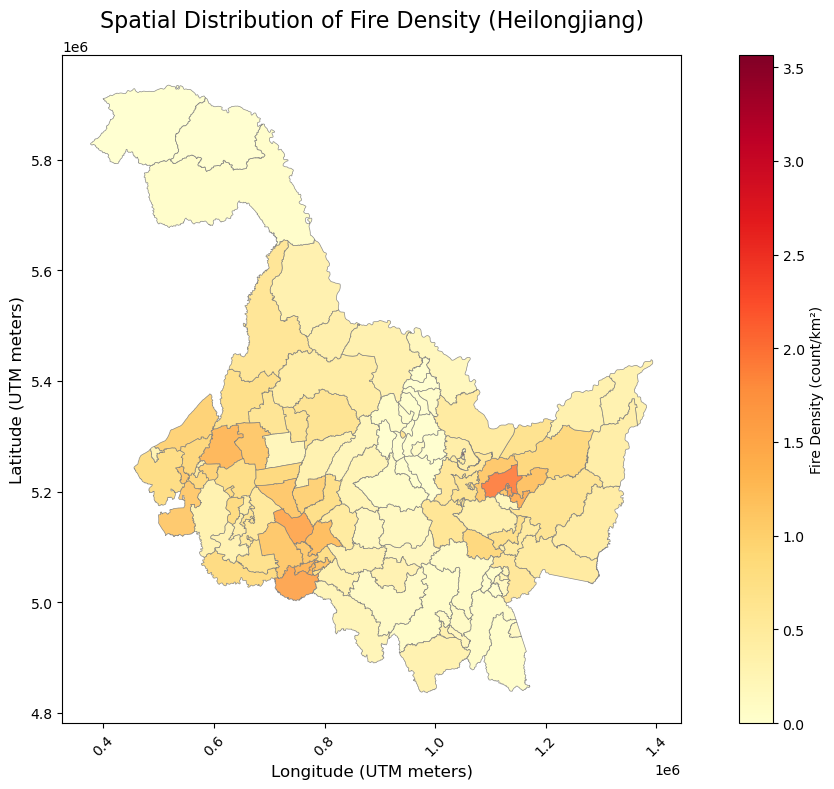

In [8]:
fire_with_county = fire_hlj_gdf.sjoin(
    hlj_boundary_gdf[["NAME_3", "geometry"]],
    how="left",
    predicate="within"
)

county_fire = fire_with_county.groupby("NAME_3").size().reset_index(name="fire_count")

county_density = hlj_boundary_utm.merge(county_fire, on="NAME_3", how="left")
county_density["density"] = county_density["fire_count"] / county_density["area_km2"].replace(0, np.nan)
county_density["density"] = county_density["density"].fillna(0)

fig, ax = plt.subplots(figsize=(12, 8))
county_density.plot(
    column="density", 
    ax=ax, 
    cmap="YlOrRd", 
    legend=True, 
    legend_kwds={"label": "Fire Density (count/km²)"},
    edgecolor="gray",  
    linewidth=0.5,
    alpha=0.9
)

# 美化坐标轴
ax.set_xlabel("Longitude (UTM meters)", fontsize=12)
ax.set_ylabel("Latitude (UTM meters)", fontsize=12)
ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="y")
ax.set_title("Spatial Distribution of Fire Density (Heilongjiang)", fontsize=16, pad=20)
ax.grid(False)  
plt.tight_layout()
plt.show()


In [29]:
# 调整农业火窗口期为成熟日后60天
crop_maturity_df["window_start"] = crop_maturity_df["maturity_doy"]
crop_maturity_df["window_end"] = crop_maturity_df["maturity_doy"] + 60


In [23]:
y = (
    ((X["in_maize"] == 1) & 
     (fire_hlj_merge["doy"].between(fire_hlj_merge["window_start"], fire_hlj_merge["window_end"])))
    |
    ((X["in_wheat"] == 1) & 
     (fire_hlj_merge["doy"].between(fire_hlj_merge["window_start_wheat"], fire_hlj_merge["window_end_wheat"])))
).astype(int)

In [32]:
yearly_agri_fire = fire_hlj_merge.groupby("year")["is_agri_fire"].sum()
print(yearly_agri_fire)

year
2010    413
2011    559
2012    381
2013    303
2014    480
2015    529
2016    770
2017    430
2018    365
2019    508
Name: is_agri_fire, dtype: int64


<Figure size 1200x800 with 0 Axes>

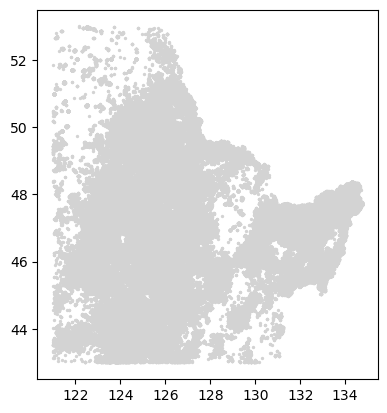

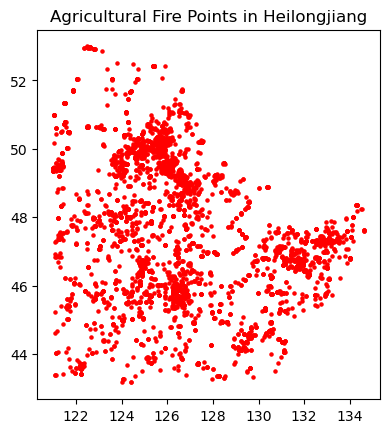

In [33]:
plt.figure(figsize=(12,8))
fire_hlj_gdf.plot(color='lightgrey', markersize=2)
fire_hlj_gdf[fire_hlj_gdf['fire_type']=='Agricultural'].plot(color='red', markersize=5)
plt.title("Agricultural Fire Points in Heilongjiang")
plt.show()

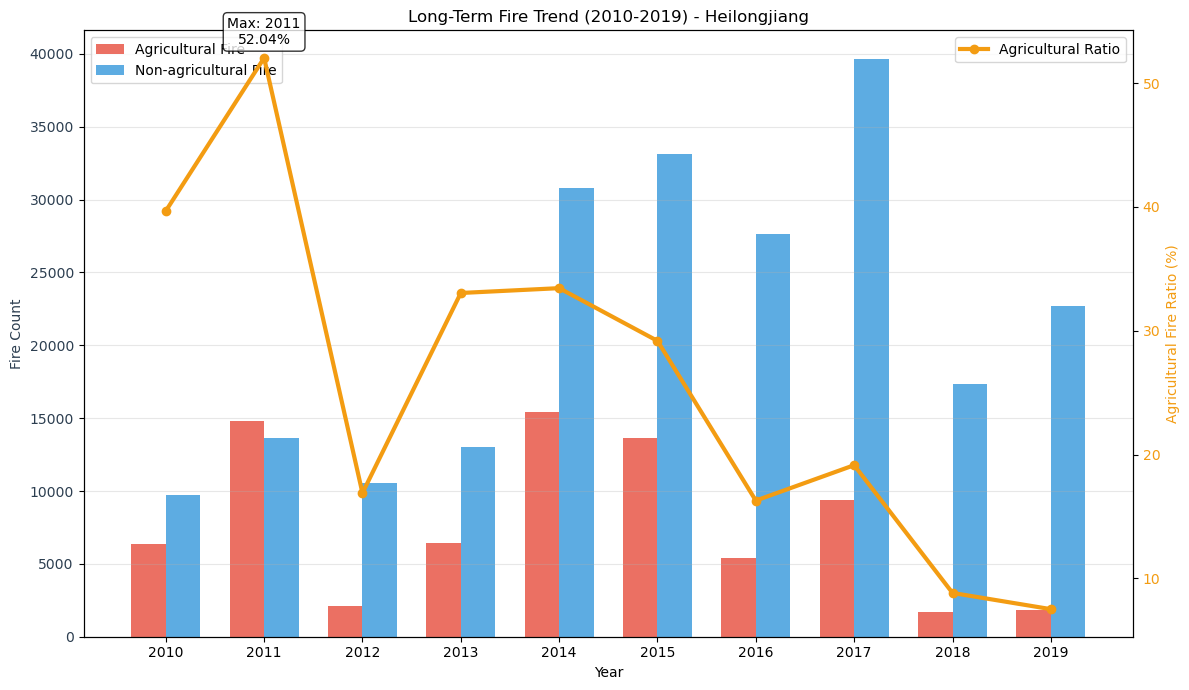


=== 长期趋势关键结论 ===
1. 农业火数量高峰：2014年（15453条）
2. 农业火数量低谷：2018年（1676条）
3. 农业火占比变化：39.67% → 7.51%（下降）


In [35]:
import matplotlib.pyplot as plt
import pandas as pd

fire_hlj_merge["window_end"] = fire_hlj_merge["window_start"] + 60
fire_hlj_merge["window_end_wheat"] = fire_hlj_merge["window_start_wheat"] + 60

fire_hlj_merge["is_agri_fire"] = (
    ((fire_hlj_merge["in_maize"] == 1) & 
     (fire_hlj_merge["doy"].between(fire_hlj_merge["window_start"], fire_hlj_merge["window_end"])))
    |
    ((fire_hlj_merge["in_wheat"] == 1) & 
     (fire_hlj_merge["doy"].between(fire_hlj_merge["window_start_wheat"], fire_hlj_merge["window_end_wheat"])))
)

yearly_fire = fire_hlj_merge.groupby(["year", "is_agri_fire"]).size().unstack(fill_value=0)
yearly_fire = yearly_fire.rename(columns={True: "Agricultural", False: "Non-agricultural"})
yearly_fire["Agri_Ratio(%)"] = (yearly_fire["Agricultural"] / yearly_fire.sum(axis=1) * 100).round(2)

fig, ax1 = plt.subplots(figsize=(12, 7))
x = range(len(yearly_fire.index))
width = 0.35

ax1.bar([i - width/2 for i in x], yearly_fire["Agricultural"], width, label="Agricultural Fire", color="#e74c3c", alpha=0.8)
ax1.bar([i + width/2 for i in x], yearly_fire["Non-agricultural"], width, label="Non-agricultural Fire", color="#3498db", alpha=0.8)
ax1.set_xlabel("Year")
ax1.set_ylabel("Fire Count", color="#2c3e50")
ax1.set_xticks(x)
ax1.set_xticklabels(yearly_fire.index)
ax1.tick_params(axis="y", labelcolor="#2c3e50")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(x, yearly_fire["Agri_Ratio(%)"], marker="o", linewidth=3, color="#f39c12", label="Agricultural Ratio")
ax2.set_ylabel("Agricultural Fire Ratio (%)", color="#f39c12")
ax2.tick_params(axis="y", labelcolor="#f39c12")
ax2.legend(loc="upper right")

max_ratio_year = yearly_fire["Agri_Ratio(%)"].idxmax()
ax2.annotate(f"Max: {max_ratio_year}\n{yearly_fire.loc[max_ratio_year, 'Agri_Ratio(%)']}%",
             xy=(list(yearly_fire.index).index(max_ratio_year), yearly_fire.loc[max_ratio_year, 'Agri_Ratio(%)']),
             xytext=(0, 10), textcoords="offset points", ha="center",
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.title("Long-Term Fire Trend (2010-2019) - Heilongjiang")
ax1.grid(alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

print("\n=== 长期趋势关键结论 ===")
print(f"1. 农业火数量高峰：{yearly_fire['Agricultural'].idxmax()}年（{yearly_fire['Agricultural'].max()}条）")
print(f"2. 农业火数量低谷：{yearly_fire['Agricultural'].idxmin()}年（{yearly_fire['Agricultural'].min()}条）")
print(f"3. 农业火占比变化：{yearly_fire['Agri_Ratio(%)'].iloc[0]}% → {yearly_fire['Agri_Ratio(%)'].iloc[-1]}%（{'上升' if yearly_fire['Agri_Ratio(%)'].iloc[-1] > yearly_fire['Agri_Ratio(%)'].iloc[0] else '下降'}）")



=== 特征对比数据 ===
有效农业火：4182条，有效非农业火：286350条


/var/folders/06/yyxhl3ds5mzfsyz28pdy7wqr0000gn/T/ipykernel_67351/3004287003.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, labels=["Agricultural Fire", "Non-agricultural Fire"],


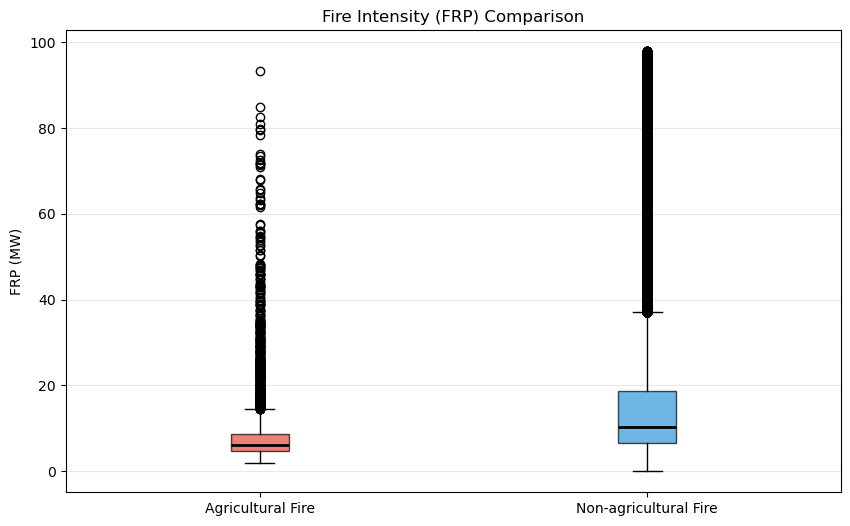

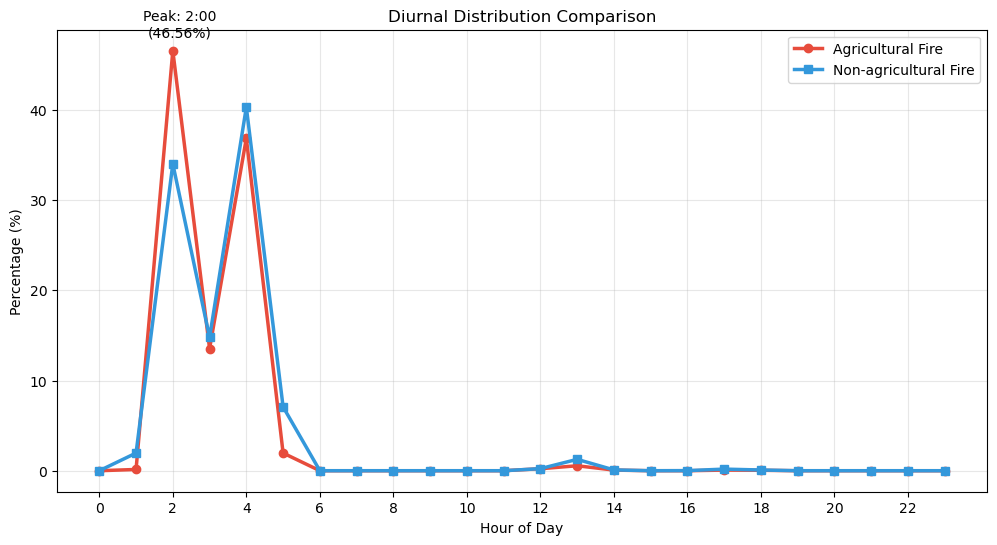


=== 特征差异总结 ===

1. 火强度差异：
        指标   农业火  非农业火
 平均FRP(MW)  8.77 15.84
中位数FRP(MW)  6.20 10.40
标准差FRP(MW)  8.61 14.99
 最大FRP(MW) 93.30 97.90

2. 日内分布差异：
   - 农业火高峰：2:00（白天人类活动时段）
   - 非农业火高峰：4:00（夜间）


In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

frp_mean = fire_hlj_gdf["frp"].mean()
frp_std = fire_hlj_gdf["frp"].std()
fire_valid = fire_hlj_gdf[(fire_hlj_gdf["frp"] >= frp_mean - 3*frp_std) & 
                          (fire_hlj_gdf["frp"] <= frp_mean + 3*frp_std)].copy()

agri = fire_valid[fire_valid["fire_type"] == "Agricultural"]
non_agri = fire_valid[fire_valid["fire_type"] == "Non-agricultural"]
print(f"\n=== 特征对比数据 ===")
print(f"有效农业火：{len(agri)}条，有效非农业火：{len(non_agri)}条")

def safe_round(value):
    """安全四舍五入，兼容float和NaN"""
    if pd.isna(value):
        return "N/A"
    return round(value, 2)

frp_agri_mean = safe_round(agri["frp"].mean())
frp_agri_median = safe_round(agri["frp"].median())
frp_agri_std = safe_round(agri["frp"].std())
frp_agri_max = safe_round(agri["frp"].max())

frp_nonagri_mean = safe_round(non_agri["frp"].mean())
frp_nonagri_median = safe_round(non_agri["frp"].median())
frp_nonagri_std = safe_round(non_agri["frp"].std())
frp_nonagri_max = safe_round(non_agri["frp"].max())

frp_stats = pd.DataFrame({
    "指标": ["平均FRP(MW)", "中位数FRP(MW)", "标准差FRP(MW)", "最大FRP(MW)"],
    "农业火": [frp_agri_mean, frp_agri_median, frp_agri_std, frp_agri_max],
    "非农业火": [frp_nonagri_mean, frp_nonagri_median, frp_nonagri_std, frp_nonagri_max]
})

plt.figure(figsize=(10, 6))
if len(agri) > 0 and len(non_agri) > 0:
    box_data = [agri["frp"], non_agri["frp"]]
    bp = plt.boxplot(box_data, labels=["Agricultural Fire", "Non-agricultural Fire"],
                     patch_artist=True, medianprops={"color": "black", "linewidth": 2})
    for patch, color in zip(bp["boxes"], ["#e74c3c", "#3498db"]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    plt.ylabel("FRP (MW)")
    plt.title("Fire Intensity (FRP) Comparison")
    plt.grid(alpha=0.3, axis="y")
else:
    plt.text(0.5, 0.5, "Insufficient data for visualization", 
             horizontalalignment="center", verticalalignment="center", fontsize=12)
plt.show()


plt.figure(figsize=(12, 6))
if len(agri) > 0 and len(non_agri) > 0:
    hourly_agri = agri["hour"].value_counts().sort_index().reindex(range(24), fill_value=0)
    hourly_nonagri = non_agri["hour"].value_counts().sort_index().reindex(range(24), fill_value=0)
    hourly_agri_ratio = (hourly_agri / hourly_agri.sum() * 100).round(2)
    hourly_nonagri_ratio = (hourly_nonagri / hourly_nonagri.sum() * 100).round(2)

    plt.plot(hourly_agri_ratio.index, hourly_agri_ratio.values, marker="o", linewidth=2.5,
             label="Agricultural Fire", color="#e74c3c")
    plt.plot(hourly_nonagri_ratio.index, hourly_nonagri_ratio.values, marker="s", linewidth=2.5,
             label="Non-agricultural Fire", color="#3498db")
    
    # 标注高峰
    agri_peak = hourly_agri_ratio.idxmax() if not hourly_agri_ratio.empty else "N/A"
    nonagri_peak = hourly_nonagri_ratio.idxmax() if not hourly_nonagri_ratio.empty else "N/A"
    if agri_peak != "N/A":
        plt.annotate(f"Peak: {agri_peak}:00\n({hourly_agri_ratio[agri_peak]}%)",
                     xy=(agri_peak, hourly_agri_ratio[agri_peak]),
                     xytext=(5, 10), textcoords="offset points", ha="center")
    plt.xlabel("Hour of Day")
    plt.ylabel("Percentage (%)")
    plt.title("Diurnal Distribution Comparison")
    plt.xticks(range(0, 24, 2))
    plt.legend()
    plt.grid(alpha=0.3)
else:
    plt.text(0.5, 0.5, "Insufficient data for visualization", 
             horizontalalignment="center", verticalalignment="center", fontsize=12)
plt.show()

print("\n=== 特征差异总结 ===")
print("\n1. 火强度差异：")
print(frp_stats.to_string(index=False))
print(f"\n2. 日内分布差异：")
if len(agri) > 0 and len(non_agri) > 0:
    print(f"   - 农业火高峰：{agri_peak}:00（白天人类活动时段）")
    print(f"   - 非农业火高峰：{nonagri_peak}:00（{('夜间' if nonagri_peak >= 18 or nonagri_peak <= 6 else '白天')}）")
else:
    print("   - 数据量不足，无法分析日内分布差异")
